## MITgcm Example 

xgcm is developed in close coordination with the [xmitgcm](http://xmitgcm.readthedocs.io/) package.
The metadata in datasets constructed by xmitgcm should always be compatible with xgcm's expectations.
xmitgcm is necessary for reading MITgcm's binary MDS file format.
However, for this example, the MDS files have already been converted and saved as netCDF.

Below are some example of how to make calculations on mitgcm-style datasets using xgcm.

First we import xarray and xgcm:

In [1]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

/Users/rpa/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Now we open the example dataset, which is stored with the xgcm github repository in the datasets folder.

In [2]:
ds = xr.open_dataset('../datasets/mitgcm_example_dataset.nc')
ds

<xarray.Dataset>
Dimensions:               (XC: 90, XG: 90, YC: 40, YG: 40, Z: 15, Zl: 15, Zp1: 16, Zu: 15, layer_1RHO_bounds: 31, layer_1RHO_center: 30, layer_1RHO_interface: 29, time: 1)
Coordinates:
  * XC                    (XC) float32 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * XG                    (XG) float32 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 ...
    rA                    (YC, XC) float32 4.11097e+10 4.11097e+10 ...
    dxG                   (YG, XC) float32 77223.1 77223.1 77223.1 77223.1 ...
    dyG                   (YC, XG) float32 444710.0 444710.0 444710.0 ...
    Depth                 (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rAz                   (YG, XG) float32 3.43349e+10 3.43349e+10 ...
    dxC                   (YC, XG) float32 92460.4 92460.4 92460.4 92460.4 ...
    dyC                   (YG, XC) float32 444710.0 444710.0 444710.0 ...
    rAw                   (YC, XG) float32 4.11097e+10 4.11097e+10 ...
    rAs                   (YG, XC) floa

### Creating the grid object

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [3]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
1RHO Axis (not periodic):
  * center   layer_1RHO_center (30) --> outer
  * outer    layer_1RHO_bounds (31) --> center
  * inner    layer_1RHO_interface (29) --> center
T Axis (not periodic):
  * center   time (1)
X Axis (periodic):
  * center   XC (90) --> left
  * left     XG (90) --> center
Z Axis (not periodic):
  * center   Z (15) --> left
  * left     Zl (15) --> center
  * outer    Zp1 (16) --> center
  * right    Zu (15) --> center
Y Axis (periodic):
  * center   YC (40) --> left
  * left     YG (40) --> center

We see that xgcm identified five different axes: X (longitude), Y (latitude), Z (depth),  T (time), and 1RHO (the axis generated by the output of the LAYERS package).

### Divergence Calculation

Here we show how to calculate the divergence of the volume transport.
The precise details of how to do this calculation are highly model- and configuration-dependent (e.g. free-surface vs. rigid lid, etc.)
In this very simple example, the flow is incompressible, satisfying the continuity equation

$$ \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} = 0 \ .$$

In discrete form, using [MITgcm notation](http://mitgcm.org/public/r2_manual/latest/online_documents/node50.html), the equation becomes

$$ \delta_i \Delta y_g \Delta r_f h_w u + \delta_j \Delta x_g \Delta r_f h_s v + \delta_k A_c w = \delta_k A_c (E - P)_{r=0} $$

where we have added the volume source due to evaporation minus precipitation at the sea surface on the RHS.

First we calculate the divergence of the horizontal flow only (u and v), i.e. the first two terms on the LHS. To begin, we multiply the u and v velocity components by the appropriate area factors to convert them to volume transports.

In [4]:
u_transport = ds.uVeltave * ds.dyG * ds.hFacW * ds.drF
v_transport = ds.vVeltave * ds.dxG * ds.hFacS * ds.drF

The `u_transport` DataArray is on the left point of the X axis, while the `v_transport` DataArray is on the left point of the Y axis.

Now comes the xgcm magic: we take the diff along both axes and divide by the cell area element to find the divergence of the horizontal flow. Note how this new variable is at the cell center point.

In [5]:
div_uv = (grid.diff(u_transport, 'X') + grid.diff(v_transport, 'Y'))
div_uv

<xarray.DataArray (time: 1, Z: 15, YC: 40, XC: 90)>
array([[[[     0.      , ...,      0.      ],
         ..., 
         [ 19427.322266, ...,  76563.859375]],

        ..., 
        [[     0.      , ...,      0.      ],
         ..., 
         [     0.      , ...,      0.      ]]]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * Z        (Z) float32 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 38.0 ...

To verify that this worked properly, we can compute the vertical sum of the horizontal convergence.
It should be equal to the vertical velocity at the top.

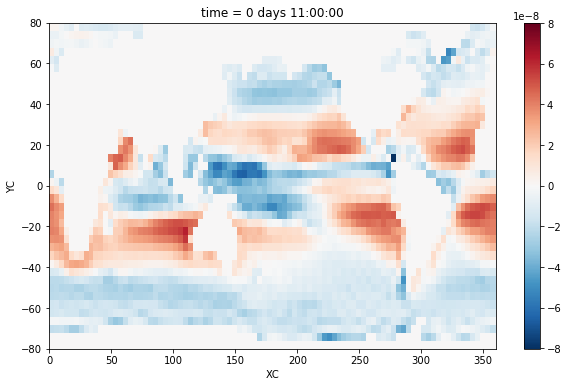

In [6]:
(-div_uv.sum(dim='Z') / ds.rA).plot();

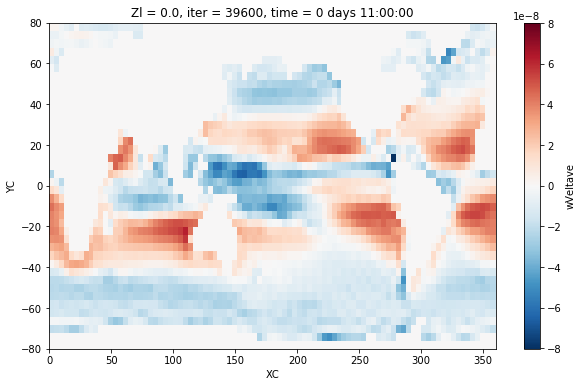

In [7]:
ds.wVeltave[0,0].plot();

Indeed these two fields look visually identical, which we can verify with a scatter plot.

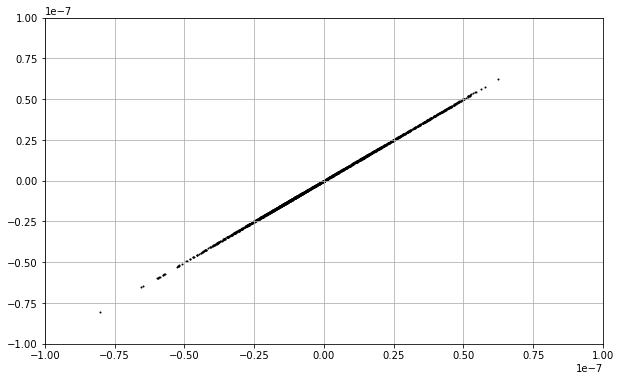

In [8]:
plt.scatter((-div_uv.sum(dim='Z') / ds.rA), ds.wVeltave[0,0], s=1)
plt.ylim([-1e-7, 1e-7])
plt.xlim([-1e-7, 1e-7])
plt.grid()

Finally, we can compute the full 3D divergence by including the vertical transport.

In [9]:
w_transport = ds.wVeltave * ds.rA
div_w = -grid.diff(w_transport, 'Z', boundary='fill')
div_w

<xarray.DataArray (time: 1, Z: 15, YC: 40, XC: 90)>
array([[[[    -0.      , ...,     -0.      ],
         ..., 
         [-19427.330078, ..., -76563.84375 ]],

        ..., 
        [[    -0.      , ...,     -0.      ],
         ..., 
         [    -0.      , ...,     -0.      ]]]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * Z        (Z) float32 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 38.0 ...

Another scatterplot shows that the divergence of the horizontal velocity is equal and opposite to the divergence of the vertical velocity.

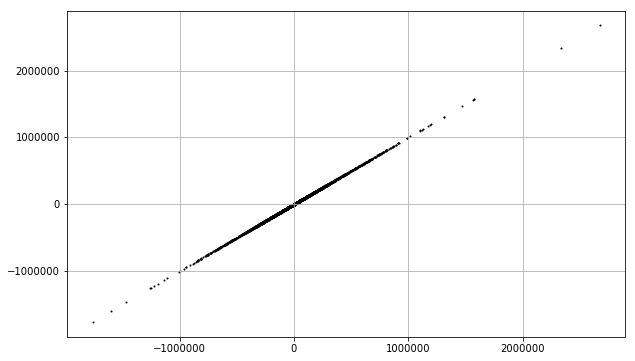

In [10]:
plt.scatter(div_uv, -div_w, s=1)
plt.grid()

### Vorticity and Strain
Here we compute more dervied quantities from the velocity field.

The vertical component of the vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \zeta = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \ . $$

On the c-grid, a finite-volume representation is given by

$$ \zeta =  (- \delta_j \Delta x_c u + \delta_i \Delta y_c v ) / A_\zeta \ . $$

In xgcm, we calculate this quanity as

In [11]:
zeta = (-grid.diff(ds.U * ds.dxC, 'Y') + grid.diff(ds.V * ds.dyC, 'X'))/ds.rAz
zeta

<xarray.DataArray (time: 1, Z: 15, YG: 40, XG: 90)>
array([[[[ -2.229010e-08, ...,  -3.268930e-08],
         ..., 
         [  6.370837e-08, ...,  -2.181051e-08]],

        ..., 
        [[  0.000000e+00, ...,   0.000000e+00],
         ..., 
         [  0.000000e+00, ...,   0.000000e+00]]]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * Z        (Z) float32 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 ...
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 -56.0 -52.0 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 36.0 ...
    rAz      (YG, XG) float32 3.43349e+10 3.43349e+10 3.43349e+10 ...

...which we can see is located at the `YG, XG` horizontal position (also commonly called the vorticity point).

We plot the vertical integral of this quantity, i.e. the barotropic vorticity:

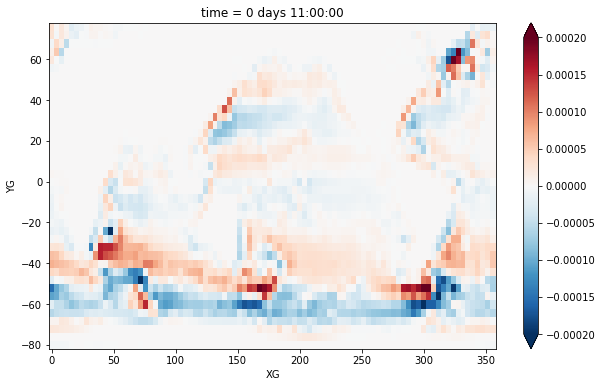

In [12]:
zeta_bt = (zeta * ds.drF).sum(dim='Z')
zeta_bt.plot(vmax=2e-4)

A different way to calculate the barotropic vorticity is to take the curl of the vertically integrated velocity.
This formulation also allows us to incorporate the $h$ factors representing partial cell thickness.

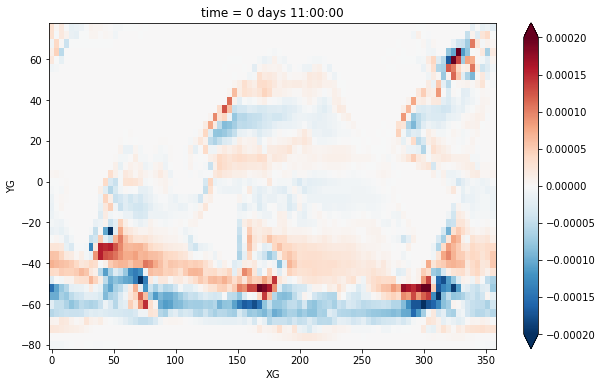

In [13]:
u_bt = (ds.U * ds.hFacW * ds.drF).sum(dim='Z')
v_bt = (ds.V * ds.hFacS * ds.drF).sum(dim='Z')
zeta_bt_alt = (-grid.diff(u_bt * ds.dxC, 'Y') + grid.diff(v_bt * ds.dyC, 'X'))/ds.rAz
zeta_bt_alt.plot(vmax=2e-4)

Another interesting quantity is the horizontal strain, defined as

$$ s = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} \ . $$

On the c-grid, a finite-volume representation is given by

$$ s =  (\delta_i \Delta y_g u - \delta_j \Delta x_g v ) / A_c \ . $$

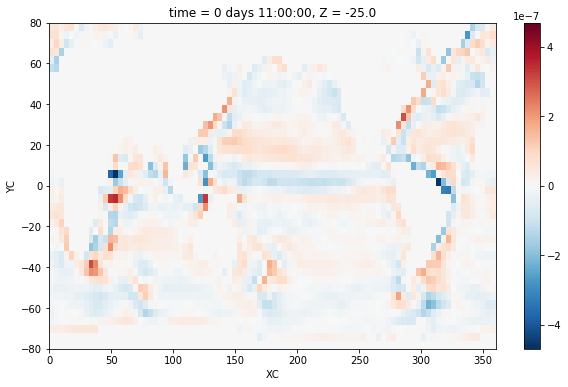

In [14]:
strain = (grid.diff(ds.U * ds.dyG, 'X') - grid.diff(ds.V * ds.dxG, 'Y')) / ds.rA
strain[0,0].plot()

### Barotropic Transport Streamfunction

We can use the barotropic velocity to calcuate the barotropic transport streamfunction, defined via

$$ u_{bt} = - \frac{\partial \Psi}{\partial y} \ , \ \ v_{bt} = \frac{\partial \Psi}{\partial x} \ .$$

We calculate this by integrating $u_{bt}$ along the Y axis using the grid object's `cumsum` method:

In [15]:
psi = grid.cumsum(-u_bt * ds.dyG, 'Y', boundary='fill')
psi

<xarray.DataArray (time: 1, YG: 40, XG: 90)>
array([[[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [ -0.000000e+00,  -0.000000e+00, ...,  -0.000000e+00,  -0.000000e+00],
        ..., 
        [ -1.041409e+08,  -1.036712e+08, ...,  -1.043609e+08,  -1.041804e+08],
        [ -1.027799e+08,  -1.027095e+08, ...,  -1.022978e+08,  -1.024666e+08]]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * YG       (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 -56.0 -52.0 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 36.0 ...

We see that xgcm automatically shifted the Y-axis position from center (YC) to left (YG) during the cumsum operation.

We convert to sverdrups and plot with a contour plot.

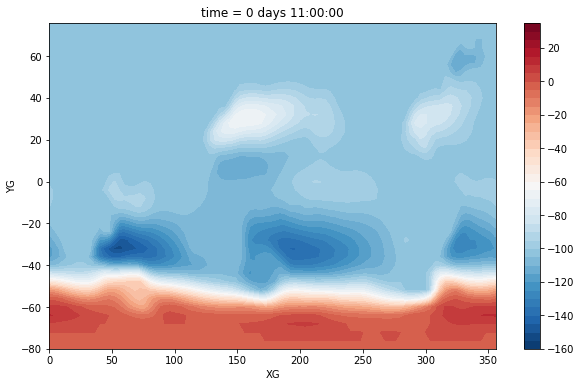

In [16]:
(psi[0] / 1e6).plot.contourf(levels=np.arange(-160, 40, 5))

### Kinetic Energy

Finally, we plot the kinetic energy $1/2 (u^2 + v^2)$ by interpoloting both quantities the cell center point.

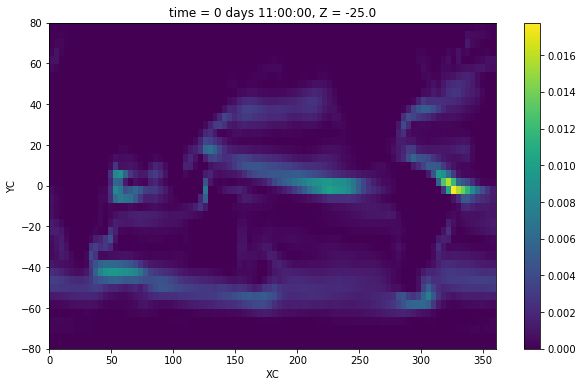

In [17]:
# an example of calculating kinetic energy
ke = 0.5*(grid.interp((ds.U*ds.hFacW)**2, 'X') + grid.interp((ds.V*ds.hFacS)**2, 'Y'))
ke[0,0].plot()